<a href="https://colab.research.google.com/github/ajaynain-eng/Hyperspectral-Image-Classification/blob/main/MLP/Spatial-Shift-MLP/Version-1/Pavia_S2_MLP_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copy

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title  { display-mode: "form" }
#@title  { display-mode: "form" }
#@title  { vertical-output: true, display-mode: "form" }
#@markdown Select the best

def str_to_bool(x):
    return True if x == "True" else False

use_pearson_corr = "False"  #@param ["True", "False"]
patch_method = "extract"    #@param ["extract", "conv"]

H, W, B = 610, 340, 103               # height,width and band of image
P_S = 9                             #@param [3, 9, 15, 21]                         
patch_size = 3                      # Size of the patches to be extract from the input images
# valid patch size is that number which is divisible by 3 i.e. 3,6,9,12

train_percent = 75          #@param [75, 80, 90]
epoch = "200"               #@param [100, 200, 300, 400]

LR_START = 3e-3
LR_MAX = 6e-3 
LR_MIN = 1e-5

batch_size = 128
BATCH_SIZE = 128
dropout = 0.2
num_patches = (P_S//patch_size)**2

num_layers = "4"              #@param [1,2,3,4,5,6,7]
expansion_factor = 4              #@param [1,2,3,4,5,6,7]
projection_dim = "512"        #@param [64, 128, 256, 512, 1024]
tokens_mlp_dim = "256"         #@param [32, 64, 128, 256, 512, 1024]
dropout_ratio = 0.0         #@param ["0.0", "0.1", "0.2", "0.3", "0.4", "0.5"]

use_pearson_corr = str_to_bool(use_pearson_corr)
P_S = int(P_S)
train_percent = int(train_percent)
epoch = int(epoch)
tokens_mlp_dim = int(tokens_mlp_dim) 
channels_mlp_dim = tokens_mlp_dim
projection_dim = int(projection_dim)
dropout_ratio = float(dropout_ratio)
num_layers = int(num_layers)
expansion_factor = int(expansion_factor)

print("Number of patches per P_S: ", num_patches)
print("Size of each patch for MLP Mixture: ", patch_size)

Number of patches per P_S:  9
Size of each patch for MLP Mixture:  3


In [3]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 11.5 MB/s eta 0:00:00


In [4]:
import pandas as pd           # for csv files and dataframes
import numpy as np            # Linear Algebra tools
import matplotlib.pyplot as plt  # for ploting graphs and curve
from matplotlib import colors, cm, gridspec
import scipy.stats as st
import scipy.io as si         # for inputing matlab files
from random import shuffle    # for shuffling dataset
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix   #Confusion matrix creation
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report

import datetime
import time
import warnings
import math
import os
import gc
import pickle

import tensorflow as tf
# import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras import activations
from tensorflow.keras.layers import Input,Add,Multiply, Reshape, Dense, Activation, BatchNormalization, Flatten, Dropout, concatenate,LayerNormalization
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D,  GlobalAveragePooling1D, GlobalAvgPool2D, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.layers import Conv2DTranspose, add, multiply, Layer, MaxPool2D, UpSampling2D, Lambda, Permute
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import glorot_uniform, Ones
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.regularizers import l2

import spectral
from imgaug import augmenters as iaa
import imgaug as ia
tfds.disable_progress_bar()
tf.random.set_seed(42)
ia.seed(42)

AUTO = tf.data.AUTOTUNE
np.random.seed(1337)          # to get reproducible results
if use_pearson_corr:
    folder_path = "/content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/pavia/With Pearson correlation/"
else:
    folder_path = "/content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/pavia/Without Pearson correlation/"

try:
    os.mkdir(folder_path)
except:
    pass

In [5]:
mat_x = si.loadmat('/content/drive/MyDrive/m_p/data/pavia/paviauni.mat')['paviaU']
mat_y = si.loadmat('/content/drive/MyDrive/m_p/data/pavia/paviauni_gt.mat')['paviaU_gt']  

x, y = np.array(mat_x).reshape(H,W,B), np.array(mat_y).reshape(H,W)
x = x.astype('float16')

# Normalizing the data between 0,1
for i in range(B):
    band_min = x[:,:,i].min()
    band_max = x[:,:,i].max()
    band_range = band_max - band_min
    x[:,:,i] = (x[:,:,i] - band_min)/band_range

pad_width = int((P_S-1)/2)
padded_x = np.pad(x,[(pad_width,pad_width),(pad_width,pad_width),(0,0)],'edge')
X,Y = [],[]
for a in range(H):
  for b in range(W):
    if(y[a][b]!= 0):
      patch = padded_x[a:a+P_S,b:b+P_S,:]
      X.append(patch)
      Y.append(y[a][b]-1)

num_classes = len(np.unique(y))-1


print("shape of mat_x: ", mat_x.shape)
print("shape of mat_y: ", mat_y.shape)
print()
print("minimum value in x is :", x.min())
print("maximum value in x is :", x.max())
print()
print("shape of x: ", x.shape)
print("shape of y: ", y.shape)
print()
print("shape of padded_x: ", padded_x.shape)
print()
print(f"{len(Y)*100/np.array(mat_y).shape[0]}% of data is labeled with {num_classes} classes")

shape of mat_x:  (610, 340, 103)
shape of mat_y:  (610, 340)

minimum value in x is : 0.0
maximum value in x is : 1.0

shape of x:  (610, 340, 103)
shape of y:  (610, 340)

shape of padded_x:  (618, 348, 103)

7012.459016393443% of data is labeled with 9 classes


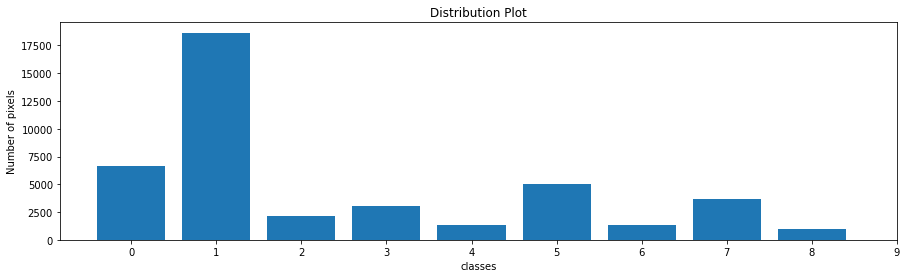

In [ ]:
class_labels, value_counts = np.unique(mat_y, return_counts = True)
plt.figure(figsize = (15,4))
plt.bar(class_labels[1:]-1, value_counts[1:])
plt.xticks(class_labels, rotation = 0)
plt.xlabel("classes")
plt.ylabel("Number of pixels")
plt.title("Distribution Plot")
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=(train_percent/100),stratify=Y, random_state=10)
x_train, x_test,y_train,y_test = tf.cast(np.array(x_train), tf.float32), tf.cast(np.array(x_test), tf.float32), np.array(y_train), np.array(y_test)
print(f"x_train: {x_train.shape} \nx_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}")

x_train: (32082, 9, 9, 103) 
x_test: (10694, 9, 9, 103) 
y_train: (32082,) 
y_test: (10694,)


### Prediction and performance measure functions

In [ ]:
def predict_half_image(model, padded_x, H, W_range, B, P_S):
    y_hat = np.zeros((H,W_range))
    for j in range(W_range):
        patchs = np.zeros((H, P_S, P_S, B))
        for i in range(H):
            patchs[i,:,:,:] = padded_x[i:i+P_S, j:j+P_S, :]
        y_pred = model.predict(patchs)
        y_pred = np.argmax(y_pred,axis=1)+1
        y_hat[:,j] = y_pred
        del patchs
        gc.collect()
    return y_hat

def predict_image(model, padded_x, H, W, B, P_S):
    start_time = time.time()
    half_1 = padded_x.shape[1]//2 + pad_width+1
    half_2 = padded_x.shape[1]//2 - pad_width-1
    padded_x_1st_half = padded_x[:,:half_1, :]
    padded_x_2nd_half = padded_x[:,half_2:, :]
    del padded_x
    gc.collect()

    y_hat = np.zeros((H,W))
    y_hat[:,:W//2] = predict_half_image(model, padded_x_1st_half, H, W//2, B, P_S)
    # del padded_x_1st_half
    print("image predicted ███████████████████████ 50%")
    gc.collect()
    if W/2 == W//2:
        y_hat[:,W//2:] = predict_half_image(model, padded_x_2nd_half, H, W//2, B, P_S)
    else:
        y_hat[:,W//2:] = predict_half_image(model, padded_x_2nd_half, H, W//2+1, B, P_S)
    # del padded_x_2nd_half
    print("image predicted ██████████████████████████████████████████████ 100%")
    gc.collect()
    end_time = time.time()
    time_taken = end_time - start_time
    time_min = time_taken//60
    time_sec = time_taken - time_min*60
    print(f'total time taken is: {time_min} min {time_sec} sec.')
    y_hat = np.reshape(y_hat, (H,W))
    print("shape of predicted image is: ", y_hat.shape)
    return y_hat

In [ ]:
def predict(model, x_test):
    y_pred = model.predict(x_test)
    y_pred1 = np.zeros((y_pred.shape[0],1))
    for a in range(y_pred.shape[0]):
        y_pred1[a] = np.argmax(y_pred[a])
    y_pred = y_pred1
    del y_pred1
    return y_pred

In [ ]:
def plot_accuracy_loss_curve(history, use_pearson_corr = None, folder_path = None):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize = (24,8))
    ax = plt.subplot(1,1,1)
    ax2 = ax.twinx()
    ax.plot(train_accuracy, color='blue', marker='o', linewidth=1.5, markersize = 2,  label = 'train_accuracy')
    ax.plot(val_accuracy, color='green', marker='o', linewidth=1.5, markersize = 2, label = 'val_accuracy')
    ax.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('accuracy')
    ax.legend()
    ax2.plot(train_loss, color = 'black', marker='o', linewidth=1.5, markersize = 2, label = 'train_loss')
    ax2.plot(val_loss, color = 'red', marker='o', linewidth=1.5, markersize = 2, label = 'val_loss')
    ax2.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('loss')
    plt.title('accuracy and loss plot for model performance')
    ax2.legend()
    plt.show()
    if folder_path:
        try:
            os.mkdir(folder_path + "Results/")
        except:
            pass
        if use_pearson_corr:
            path = folder_path + "Results/Pearson_Corr " + str(train_percent) + "% ps_"+ str(P_S) + " accuracy_loss.png"
        else:
            path = folder_path + "Results/" + str(train_percent) + "% ps_"+ str(P_S) + " accuracy_loss.png"
        fig.savefig(path)

In [ ]:
def performance_meausures(y_test, y_pred, tt, *parameters_summary, use_pearson_corr = None, folder_path = None):
    Total_params, Trainable_params, Non_trainable_params = parameters_summary
    accuracy = accuracy_score(y_test, y_pred)
    kappa=cohen_kappa_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred).astype('int32')
    cr = classification_report(y_test, y_pred, output_dict=True)
    df_cr = pd.DataFrame(cr).T
    df_score = pd.DataFrame({'accuracy score: ' : [accuracy], 'Cohen_Kappa score: ' : [kappa], "Training Time: " : [tt]}).T
    df_summary = pd.DataFrame({'Total_params: ': [Total_params], 'Trainable_params: ' : [Trainable_params], 'Non_trainable_params: ':[Non_trainable_params]}).T

    spec = gridspec.GridSpec(ncols = 2, nrows = 2, width_ratios=[1,3], wspace = 0.5, hspace = 0.5, height_ratios=[7,1])
    
    fig = plt.figure(figsize = (24,10))

    ax1 = fig.add_subplot(spec[0])
    ax1.set_title('classification report')
    sns.heatmap(df_cr, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax1)

    ax2 = fig.add_subplot(spec[1])
    ax2.set_title('confusion matrix')
    ax2.set_xlabel('predicted class')
    ax2.set_ylabel('actual class')
    sns.heatmap(cm, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax2)

    ax3 = fig.add_subplot(spec[2])
    sns.heatmap(df_score, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax3)

    ax4 = fig.add_subplot(spec[3])
    sns.heatmap(df_summary, cmap = "Blues", cbar = False, annot = True, fmt=' .10g', ax = ax4)

    try:
        os.mkdir(folder_path + "Results/" )
    except:
        pass

    if folder_path:
        if use_pearson_corr:
            path = folder_path + "Results/" + str(train_percent) + "% ps_" + str(P_S) +" Performance Measure" + ".png"
        else:
            path = folder_path + "Results/" + str(train_percent) + "% ps_" + str(P_S)+ " Performance Measure" + ".png"
        fig.savefig(path)

### Building the classes and function for model

In [ ]:
class Pearson_correlation_masked(layers.Layer):
    def __init__(self, P_S = 9, **kwargs):
        super(Pearson_correlation_masked, self).__init__(**kwargs)
        self.P_S = P_S
    
    def call(self, inputs):
        self.loc = (self.P_S)//2
        self.inputs = inputs
        self.channels = self.inputs.shape[-1]
        self.x_mean = tf.repeat(tf.math.reduce_mean(self.inputs, axis = -1, keepdims=True), repeats = self.channels, axis = -1)

        self.y = tf.repeat(tf.repeat(self.inputs[:,self.loc:self.loc+1, self.loc:self.loc+1, :], repeats = self.P_S, axis = -2), repeats = self.P_S, axis = -3)

        self.y_mean = tf.repeat(tf.math.reduce_mean(self.y, axis = -1, keepdims = True), repeats = self.channels, axis = -1)

        self.a = tf.math.subtract(self.inputs, self.x_mean)
        self.b = tf.math.subtract(self.y, self.y_mean)
        self.ab = tf.math.multiply(self.a,self.b)
        self.num = tf.math.reduce_sum(self.ab, axis = -1, keepdims = True)

        self.a_new = tf.math.reduce_sum(tf.math.multiply(self.a, self.a), axis = -1, keepdims = True)
        self.b_new = tf.math.reduce_sum(tf.math.multiply(self.b, self.b), axis = -1, keepdims = True)
        self.deno = tf.math.sqrt(tf.math.multiply(self.a_new, self.b_new))
    
        self.corr = tf.math.divide(self.num, self.deno)

        self.thresh = tf.math.reduce_mean(self.corr)
        self.mask = self.corr > self.thresh
        self.mask = tf.cast(self.mask, self.corr.dtype)

        self.masked_corr = tf.math.multiply(self.mask, self.corr)
    
        self.attention_weights = tf.repeat(self.masked_corr, repeats = self.channels, axis = -1)
        return multiply([self.inputs, self.attention_weights])

    def get_config(self, **kwargs):
        config = super().get_config()
        config.update({
            "P_S": self.P_S,
        })
        return config

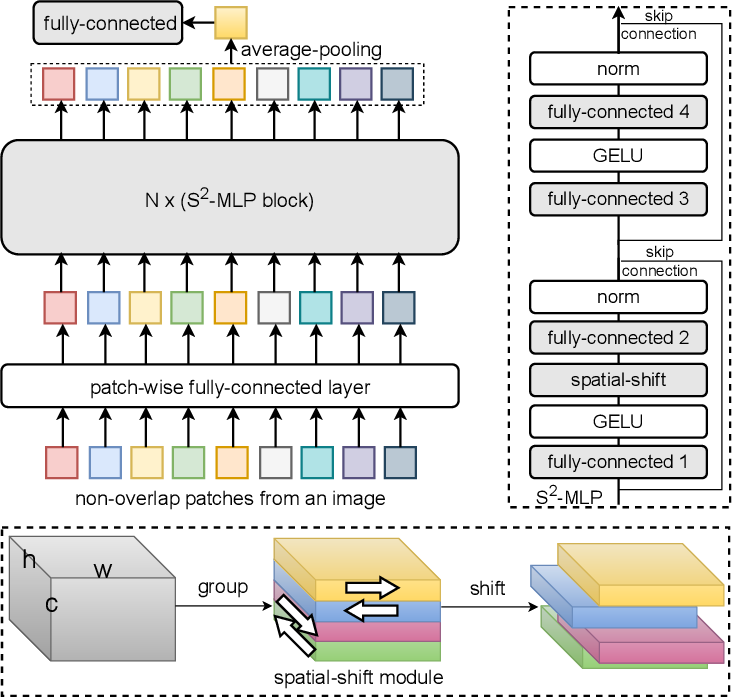

In [ ]:
class Patches(layers.Layer):
    def __init__(self, hidden_dim = 256, patch_size = 3, patch_method='extract', **kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.patch_method = patch_method.lower()

    def call(self, images):
        if self.patch_method == "conv":
            x = Conv2D(self.hidden_dim, patch_size, patch_size)(images)              # shape(B, 3, 3, 256)
            patches = Reshape([-1, x.shape[-1]])(x)                                   # shape(B, 9, 256)
            return patches
        else:
            batch_size = tf.shape(images)[0]
            patches = tf.image.extract_patches(images=images, sizes=[1, self.patch_size, self.patch_size, 1], strides=[1, self.patch_size, self.patch_size, 1],
                                            rates=[1, 1, 1, 1], padding="VALID",)
            patch_dims = patches.shape[-1]
            patches = tf.reshape(patches, [batch_size, -1, patch_dims])
            return patches
    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
            "hidden_dim": self.hidden_dim,
            "patch_method": self.patch_method
        })
        return config

In [ ]:
def mlp_block(x, hidden_dim, dropout_ratio = 0.1):
    y = Dense(hidden_dim)(x)
    y = tf.nn.gelu(y)
    y = Dropout(dropout_ratio)(y)
    return Dense(x.shape[-1])(y)

In [ ]:
class Linear(layers.Layer):
    def __init__(self, units = 32, bias = True, **kwargs):
        super(Linear, self).__init__(**kwargs)
        self.units = units
        self.bias = bias
    
    def build(self, input_shape):
        # initialize the weights
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(name="kernel", initial_value=w_init(shape=(input_shape[-1], self.units), dtype='float32'),trainable=True)
        if self.bias:
            b_init = tf.zeros_initializer()
            self.b = tf.Variable(name="bias",initial_value=b_init(shape=(self.units,), dtype='float32'),trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
    def get_config(self, **kwargs):
        config = super().get_config()
        config.update({
            "units": self.units,
            "bias" : self.bias
        })
        return config

In [ ]:
class Spatial_Shift(layers.Layer):
    def __init__(self, **kwargs):
        super(Spatial_Shift, self).__init__(**kwargs)
    
    def forward(self, x, **kwargs):
        b,w,h,c = x.shape
        x[:,1:,:,:c//4] = x[:,:w-1,:,:c//4]
        x[:,:w-1,:,c//4:c//2] = x[:,1:,:,c//4:c//2]
        x[:,:,1:,c//2:c*3//4] = x[:,:,:h-1,c//2:c*3//4]
        x[:,:,:h-1,3*c//4:] = x[:,:,1:,3*c//4:]
        return x

In [ ]:
class Shifted_MLP(layers.Layer):
    def __init__(self, d_model, expansion_factor = 4, dropout = 0.0, **kwargs):
        super(Shifted_MLP, self).__init__(**kwargs)
        self.d_model = d_model
        self.expansion_factor = expansion_factor
        self.dropout = dropout

        self.norm1 = LayerNormalization(axis = -1, epsilon=1e-6)
        self.norm2 = LayerNormalization(axis = -1, epsilon=1e-6)
        self.linear1 = Linear(d_model, bias = True)
        self.act = activations.gelu
        self.shift = Spatial_Shift()
        self.linear2 = Linear(d_model)
        self.linear3 = Linear(d_model * expansion_factor, bias = True)
        self.linear4 = Linear(d_model, bias = True)
        self.dropout = Dropout(rate = dropout)

    def block_1(self, x):
        x = self.linear1(x)
        x = self.act(x)
        x = self.shift(x)
        x = self.linear2(x)
        return x

    def block_2(self, x):
        x = self.linear3(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.linear4(x)
        x = self.dropout(x)
        return x

    def call(self, x, depth):
        for _ in range(depth):
            x = self.block_1(self.norm1(x)) + x
            x = self.block_2(self.norm2(x)) + x
        return x

    def get_config(self, **kwargs):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "expansion_factor" : self.expansion_factor,
            "dropout": self.dropout,
        })
        return config

In [ ]:
def S2_MLP_model(input_shape = (P_S, P_S, B), patch_size = 3, num_classes = 7, use_pearson_corr = False, num_layers = 4,
                    projection_dim = 256, tokens_mlp_dim = 128, expansion_factor = 4, dropout_ratio = 0.0, patch_method='extract'):
    inputs = layers.Input(shape=input_shape)                                          # shape = (9,9,372)
    b = inputs.shape[0]
    if use_pearson_corr:
        x0 = Pearson_correlation_masked(P_S)(inputs)                                  # shape = (9,9,372)
    else:
        x0 = inputs
    
    patches = Patches(hidden_dim = projection_dim, patch_size = patch_size, patch_method=patch_method)(x0)
    # if tokens_mlp_dim != projection_dim:
    patches = Dense(tokens_mlp_dim)(patches)
        
    x = Shifted_MLP(d_model = tokens_mlp_dim, expansion_factor = expansion_factor, dropout = dropout_ratio)(patches, num_layers)
    # x = Shifted_MLP(d_model = tokens_mlp_dim, depth = num_layers, expansion_factor = expansion_factor, dropout = dropout_ratio)(patches)


    x = Linear(num_classes)(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation="softmax", dtype="float32")(x)
    
    model = Model(inputs = inputs, outputs = outputs, name = "S2-MLP")
    return model

In [ ]:
model = S2_MLP_model((P_S, P_S, B), patch_size , num_classes, use_pearson_corr, num_layers,
                        projection_dim, tokens_mlp_dim,expansion_factor, dropout_ratio, patch_method)

In [ ]:
model.summary()

Model: "S2-MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 9, 103)]       0         
                                                                 
 patches (Patches)           (None, None, 927)         0         
                                                                 
 dense (Dense)               (None, None, 256)         237568    
                                                                 
 shifted_mlp (Shifted_MLP)   (None, None, 256)         658176    
                                                                 
 linear_4 (Linear)           (None, None, 9)           2313      
                                                                 
 global_average_pooling1d (G  (None, 9)                0         
 lobalAveragePooling1D)                                          
                                                            

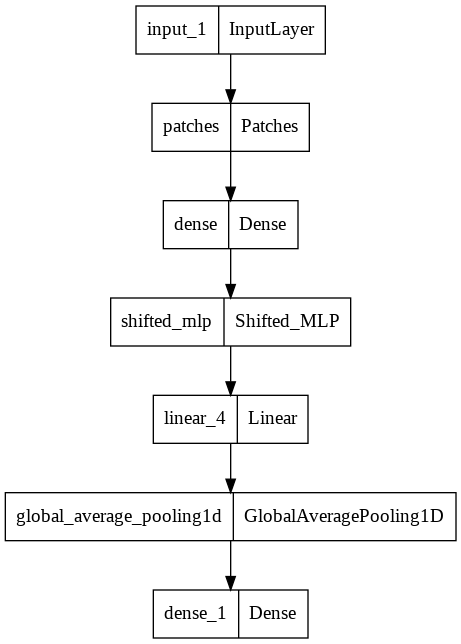

In [ ]:
plot_model(model)

Learning rate schedule: 0.0006 to 0.0006 to 1e-07


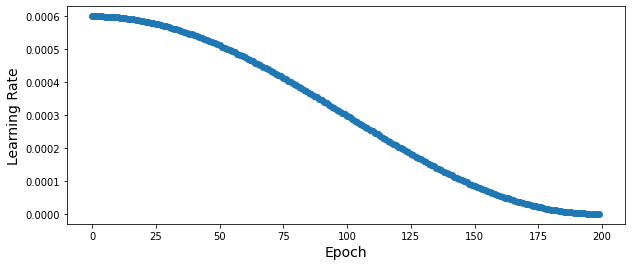

In [ ]:
LR_START = 3e-4
LR_MAX = 6e-4 
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = epoch
STEPS = [epoch,epoch*2]

def lrfn(epoch):
    if epoch<STEPS[0]:
        epoch2 = epoch
        EPOCHS2 = STEPS[0]
    elif epoch<STEPS[0]+STEPS[1]:
        epoch2 = epoch-STEPS[0]
        EPOCHS2 = STEPS[1]
    elif epoch<STEPS[0]+STEPS[1]+STEPS[2]:
        epoch2 = epoch-STEPS[0]-STEPS[1]
        EPOCHS2 = STEPS[2]
    
    if epoch2 < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch2 + LR_START
    elif epoch2 < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
          format(lr_y[0], max(lr_y), lr_y[-1]))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
plt.xlabel('Epoch',size=14)
plt.ylabel('Learning Rate',size=14)
plt.show()

In [ ]:
filepath = folder_path +"Trained models/"+ str(train_percent)+"% ps_"+str(P_S)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
callbacks_list = [checkpoint, lr_callback]
model.compile(optimizer=optimizers.Adam(0.000003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# history = model.fit(train_dataset, validation_data = (test_dataset), validation_freq = 1, batch_size = 32, callbacks=callbacks_list, shuffle = False, epochs=epochs)
start_time = time.time()
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), validation_freq = 1, batch_size = BATCH_SIZE, callbacks=callbacks_list, shuffle = False, 
                    epochs=epoch, use_multiprocessing=True)
end_time = time.time()
tt = end_time - start_time
print("total training time: ", tt)


Epoch 1: LearningRateScheduler setting learning rate to 0.0006.
Epoch 1/200
251/251 [==============================] - ETA: 0s - loss: 0.8682 - accuracy: 0.7107
Epoch 1: val_accuracy improved from -inf to 0.79951, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/pavia/Without Pearson correlation/Trained models/75% ps_9


251/251 [==============================] - 28s 74ms/step - loss: 0.8682 - accuracy: 0.7107 - val_loss: 0.4241 - val_accuracy: 0.7995 - lr: 6.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005999626230858212.
Epoch 2/200
251/251 [==============================] - ETA: 0s - loss: 0.4012 - accuracy: 0.8356
Epoch 2: val_accuracy improved from 0.79951 to 0.85777, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/pavia/Without Pearson correlation/Trained models/75% ps_9


251/251 [==============================] - 15s 59ms/step - loss: 0.4012 - accuracy: 0.8356 - val_loss: 0.4156 - val_accuracy: 0.8578 - lr: 5.9996e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005998505016583958.
Epoch 3/200
250/251 [============================>.] - ETA: 0s - loss: 0.3574 - accuracy: 0.8597
Epoch 3: val_accuracy improved from 0.85777 to 0.89499, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/pavia/Without Pearson correlation/Trained models/75% ps_9


251/251 [==============================] - 15s 59ms/step - loss: 0.3576 - accuracy: 0.8595 - val_loss: 0.2898 - val_accuracy: 0.8950 - lr: 5.9985e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0005996636636607337.
Epoch 4/200
251/251 [==============================] - ETA: 0s - loss: 0.2905 - accuracy: 0.8869
Epoch 4: val_accuracy improved from 0.89499 to 0.93529, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/pavia/Without Pearson correlation/Trained models/75% ps_9


251/251 [==============================] - 15s 60ms/step - loss: 0.2905 - accuracy: 0.8869 - val_loss: 0.1831 - val_accuracy: 0.9353 - lr: 5.9966e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0005994021556567814.
Epoch 5/200
250/251 [============================>.] - ETA: 0s - loss: 0.1945 - accuracy: 0.9224
Epoch 5: val_accuracy improved from 0.93529 to 0.93604, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/pavia/Without Pearson correlation/Trained models/75% ps_9


251/251 [==============================] - 15s 58ms/step - loss: 0.1950 - accuracy: 0.9222 - val_loss: 0.1670 - val_accuracy: 0.9360 - lr: 5.9940e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0005990660428198156.
Epoch 6/200
251/251 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 0.9245
Epoch 6: val_accuracy improved from 0.93604 to 0.94969, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/pavia/Without Pearson correlation/Trained models/75% ps_9


251/251 [==============================] - 15s 58ms/step - loss: 0.2040 - accuracy: 0.9245 - val_loss: 0.1639 - val_accuracy: 0.9497 - lr: 5.9907e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.0005986554089162017.
Epoch 7/200
250/251 [============================>.] - ETA: 0s - loss: 0.2227 - accuracy: 0.9199
Epoch 7: val_accuracy improved from 0.94969 to 0.96980, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/pavia/Without Pearson correlation/Trained models/75% ps_9


251/251 [==============================] - 17s 68ms/step - loss: 0.2225 - accuracy: 0.9199 - val_loss: 0.0820 - val_accuracy: 0.9698 - lr: 5.9866e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0005981703562845174.
Epoch 8/200
250/251 [============================>.] - ETA: 0s - loss: 0.1138 - accuracy: 0.9571
Epoch 8: val_accuracy improved from 0.96980 to 0.97812, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/pavia/Without Pearson correlation/Trained models/75% ps_9


251/251 [==============================] - 15s 58ms/step - loss: 0.1136 - accuracy: 0.9572 - val_loss: 0.0614 - val_accuracy: 0.9781 - lr: 5.9817e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0005976110058100476.
Epoch 9/200
251/251 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9271
Epoch 9: val_accuracy did not improve from 0.97812
251/251 [==============================] - 12s 47ms/step - loss: 0.1979 - accuracy: 0.9271 - val_loss: 0.1366 - val_accuracy: 0.9518 - lr: 5.9761e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0005969774968946571.
Epoch 10/200
250/251 [============================>.] - ETA: 0s - loss: 0.1176 - accuracy: 0.9548
Epoch 10: val_accuracy did not improve from 0.97812
251/251 [==============================] - 12s 47ms/step - loss: 0.1179 - accuracy: 0.9548 - val_loss: 0.0843 - val_accuracy: 0.9696 - lr: 5.9698e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0005962699874220488.
Epoch 11/2

251/251 [==============================] - 15s 58ms/step - loss: 0.0877 - accuracy: 0.9678 - val_loss: 0.0559 - val_accuracy: 0.9794 - lr: 5.9463e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0005937053108670514.
Epoch 14/200
250/251 [============================>.] - ETA: 0s - loss: 0.1080 - accuracy: 0.9626
Epoch 14: val_accuracy did not improve from 0.97943
251/251 [==============================] - 12s 47ms/step - loss: 0.1084 - accuracy: 0.9624 - val_loss: 0.1516 - val_accuracy: 0.9444 - lr: 5.9371e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0005927037461657453.
Epoch 15/200
251/251 [==============================] - ETA: 0s - loss: 0.1022 - accuracy: 0.9621
Epoch 15: val_accuracy improved from 0.97943 to 0.98541, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/pavia/Without Pearson correlation/Trained models/75% ps_9


251/251 [==============================] - 15s 60ms/step - loss: 0.1022 - accuracy: 0.9621 - val_loss: 0.0370 - val_accuracy: 0.9854 - lr: 5.9270e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0005916292460155008.
Epoch 16/200
251/251 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.9775
Epoch 16: val_accuracy did not improve from 0.98541
251/251 [==============================] - 12s 47ms/step - loss: 0.0686 - accuracy: 0.9775 - val_loss: 0.0706 - val_accuracy: 0.9715 - lr: 5.9163e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.0005904820782042822.
Epoch 17/200
251/251 [==============================] - ETA: 0s - loss: 0.1560 - accuracy: 0.9455
Epoch 17: val_accuracy did not improve from 0.98541
251/251 [==============================] - 12s 47ms/step - loss: 0.1560 - accuracy: 0.9455 - val_loss: 0.0900 - val_accuracy: 0.9661 - lr: 5.9048e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.0005892625286303579.
Epoch 1

251/251 [==============================] - 15s 58ms/step - loss: 0.0604 - accuracy: 0.9784 - val_loss: 0.0237 - val_accuracy: 0.9916 - lr: 5.8661e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0005851727184418655.
Epoch 21/200
250/251 [============================>.] - ETA: 0s - loss: 0.0439 - accuracy: 0.9837
Epoch 21: val_accuracy did not improve from 0.99158
251/251 [==============================] - 12s 48ms/step - loss: 0.0438 - accuracy: 0.9837 - val_loss: 0.0257 - val_accuracy: 0.9905 - lr: 5.8517e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0005836668604178043.
Epoch 22/200
250/251 [============================>.] - ETA: 0s - loss: 0.1449 - accuracy: 0.9537
Epoch 22: val_accuracy did not improve from 0.99158
251/251 [==============================] - 12s 47ms/step - loss: 0.1447 - accuracy: 0.9538 - val_loss: 0.0846 - val_accuracy: 0.9723 - lr: 5.8367e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.000582090319126189.
Epoch 23

251/251 [==============================] - 15s 59ms/step - loss: 0.0472 - accuracy: 0.9832 - val_loss: 0.0196 - val_accuracy: 0.9932 - lr: 5.7873e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0005769406122043028.
Epoch 26/200
251/251 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9873
Epoch 26: val_accuracy improved from 0.99317 to 0.99476, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/pavia/Without Pearson correlation/Trained models/75% ps_9


251/251 [==============================] - 15s 60ms/step - loss: 0.0379 - accuracy: 0.9873 - val_loss: 0.0168 - val_accuracy: 0.9948 - lr: 5.7694e-04

Epoch 27: LearningRateScheduler setting learning rate to 0.0005750854415764269.
Epoch 27/200
250/251 [============================>.] - ETA: 0s - loss: 0.0436 - accuracy: 0.9857
Epoch 27: val_accuracy did not improve from 0.99476
251/251 [==============================] - 12s 47ms/step - loss: 0.0436 - accuracy: 0.9857 - val_loss: 0.0253 - val_accuracy: 0.9912 - lr: 5.7509e-04

Epoch 28: LearningRateScheduler setting learning rate to 0.0005731617263504788.
Epoch 28/200
250/251 [============================>.] - ETA: 0s - loss: 0.0598 - accuracy: 0.9800
Epoch 28: val_accuracy did not improve from 0.99476
251/251 [==============================] - 12s 47ms/step - loss: 0.0597 - accuracy: 0.9800 - val_loss: 0.0605 - val_accuracy: 0.9760 - lr: 5.7316e-04

Epoch 29: LearningRateScheduler setting learning rate to 0.0005711699459566226.
Epoch 2

251/251 [==============================] - 15s 58ms/step - loss: 0.0253 - accuracy: 0.9921 - val_loss: 0.0157 - val_accuracy: 0.9954 - lr: 5.5537e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0005528484271758601.
Epoch 37/200
250/251 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9953
Epoch 37: val_accuracy improved from 0.99542 to 0.99738, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/pavia/Without Pearson correlation/Trained models/75% ps_9


251/251 [==============================] - 15s 59ms/step - loss: 0.0143 - accuracy: 0.9953 - val_loss: 0.0077 - val_accuracy: 0.9974 - lr: 5.5285e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0005502683908185693.
Epoch 38/200
250/251 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9768
Epoch 38: val_accuracy did not improve from 0.99738
251/251 [==============================] - 12s 47ms/step - loss: 0.0735 - accuracy: 0.9769 - val_loss: 0.0288 - val_accuracy: 0.9890 - lr: 5.5027e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0005476259947925368.
Epoch 39/200
251/251 [==============================] - ETA: 0s - loss: 0.0452 - accuracy: 0.9854
Epoch 39: val_accuracy did not improve from 0.99738
251/251 [==============================] - 12s 47ms/step - loss: 0.0452 - accuracy: 0.9854 - val_loss: 0.0181 - val_accuracy: 0.9935 - lr: 5.4763e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.000544921897638249.
Epoch 40

251/251 [==============================] - 15s 58ms/step - loss: 0.0261 - accuracy: 0.9907 - val_loss: 0.0087 - val_accuracy: 0.9976 - lr: 5.2432e-04

Epoch 48: LearningRateScheduler setting learning rate to 0.000521151899794158.
Epoch 48/200
250/251 [============================>.] - ETA: 0s - loss: 0.0512 - accuracy: 0.9845
Epoch 48: val_accuracy did not improve from 0.99757
251/251 [==============================] - 12s 47ms/step - loss: 0.0511 - accuracy: 0.9845 - val_loss: 0.0129 - val_accuracy: 0.9959 - lr: 5.2115e-04

Epoch 49: LearningRateScheduler setting learning rate to 0.0005179246068918286.
Epoch 49/200
251/251 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9968
Epoch 49: val_accuracy did not improve from 0.99757
251/251 [==============================] - 12s 47ms/step - loss: 0.0093 - accuracy: 0.9968 - val_loss: 0.0102 - val_accuracy: 0.9962 - lr: 5.1792e-04

Epoch 50: LearningRateScheduler setting learning rate to 0.0005146430150697889.
Epoch 50

251/251 [==============================] - 15s 61ms/step - loss: 0.0085 - accuracy: 0.9973 - val_loss: 0.0079 - val_accuracy: 0.9978 - lr: 5.1464e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.000511307942169519.
Epoch 51/200
250/251 [============================>.] - ETA: 0s - loss: 0.0279 - accuracy: 0.9910
Epoch 51: val_accuracy did not improve from 0.99785
251/251 [==============================] - 12s 47ms/step - loss: 0.0278 - accuracy: 0.9911 - val_loss: 0.0121 - val_accuracy: 0.9959 - lr: 5.1131e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.000507920219361104.
Epoch 52/200
251/251 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9802
Epoch 52: val_accuracy did not improve from 0.99785
251/251 [==============================] - 12s 47ms/step - loss: 0.0593 - accuracy: 0.9802 - val_loss: 0.0265 - val_accuracy: 0.9894 - lr: 5.0792e-04

Epoch 53: LearningRateScheduler setting learning rate to 0.0005044806909360905.
Epoch 53/

251/251 [==============================] - 15s 58ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0036 - val_accuracy: 0.9989 - lr: 4.4314e-04

Epoch 70: LearningRateScheduler setting learning rate to 0.0004389596903617983.
Epoch 70/200
250/251 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 0.9996
Epoch 70: val_accuracy did not improve from 0.99888
251/251 [==============================] - 12s 47ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0058 - val_accuracy: 0.9974 - lr: 4.3896e-04

Epoch 71: LearningRateScheduler setting learning rate to 0.0004347456713241519.
Epoch 71/200
251/251 [==============================] - ETA: 0s - loss: 0.0553 - accuracy: 0.9840
Epoch 71: val_accuracy did not improve from 0.99888
251/251 [==============================] - 12s 47ms/step - loss: 0.0553 - accuracy: 0.9840 - val_loss: 0.0521 - val_accuracy: 0.9832 - lr: 4.3475e-04

Epoch 72: LearningRateScheduler setting learning rate to 0.00043049808330135916.
Epoch 

251/251 [==============================] - 15s 58ms/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.0041 - val_accuracy: 0.9990 - lr: 4.0437e-04

Epoch 79: LearningRateScheduler setting learning rate to 0.00039991494417707693.
Epoch 79/200
251/251 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9978
Epoch 79: val_accuracy improved from 0.99897 to 0.99916, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/pavia/Without Pearson correlation/Trained models/75% ps_9


251/251 [==============================] - 15s 60ms/step - loss: 0.0061 - accuracy: 0.9978 - val_loss: 0.0043 - val_accuracy: 0.9992 - lr: 3.9991e-04

Epoch 80: LearningRateScheduler setting learning rate to 0.00039543756029495946.
Epoch 80/200
251/251 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.9929
Epoch 80: val_accuracy did not improve from 0.99916
251/251 [==============================] - 12s 47ms/step - loss: 0.0275 - accuracy: 0.9929 - val_loss: 0.0400 - val_accuracy: 0.9875 - lr: 3.9544e-04

Epoch 81: LearningRateScheduler setting learning rate to 0.00039093640383304647.
Epoch 81/200
251/251 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9964
Epoch 81: val_accuracy did not improve from 0.99916
251/251 [==============================] - 12s 47ms/step - loss: 0.0105 - accuracy: 0.9964 - val_loss: 0.0103 - val_accuracy: 0.9965 - lr: 3.9094e-04

Epoch 82: LearningRateScheduler setting learning rate to 0.0003864125965738934.
Epoch

251/251 [==============================] - 15s 58ms/step - loss: 1.5545e-04 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 0.9995 - lr: 3.4954e-04

Epoch 91: LearningRateScheduler setting learning rate to 0.0003448667100744831.
Epoch 91/200
251/251 [==============================] - ETA: 0s - loss: 8.8614e-05 - accuracy: 1.0000
Epoch 91: val_accuracy did not improve from 0.99953
251/251 [==============================] - 12s 47ms/step - loss: 8.8614e-05 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 0.9995 - lr: 3.4487e-04

Epoch 92: LearningRateScheduler setting learning rate to 0.0003401791947173385.
Epoch 92/200
250/251 [============================>.] - ETA: 0s - loss: 6.9072e-05 - accuracy: 1.0000
Epoch 92: val_accuracy did not improve from 0.99953
251/251 [==============================] - 12s 47ms/step - loss: 6.8925e-05 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 0.9993 - lr: 3.4018e-04

Epoch 93: LearningRateScheduler setting learning rate to 0.00033548

In [ ]:
Trainable_params = 0
for i in model.trainable_weights :
    Trainable_params+= np.prod(i.shape)

Non_trainable_params = 0
for i in model.non_trainable_weights:
    Non_trainable_params+= np.prod(i.shape)

Total_params = Trainable_params + Non_trainable_params
parameters_summary = [Total_params, Trainable_params, Non_trainable_params]

print("Total_params: ", Total_params)
print("Trainable_params: ", Trainable_params)
print("Non_trainable_params: ", Non_trainable_params)

Total_params:  898147
Trainable_params:  898147
Non_trainable_params:  0


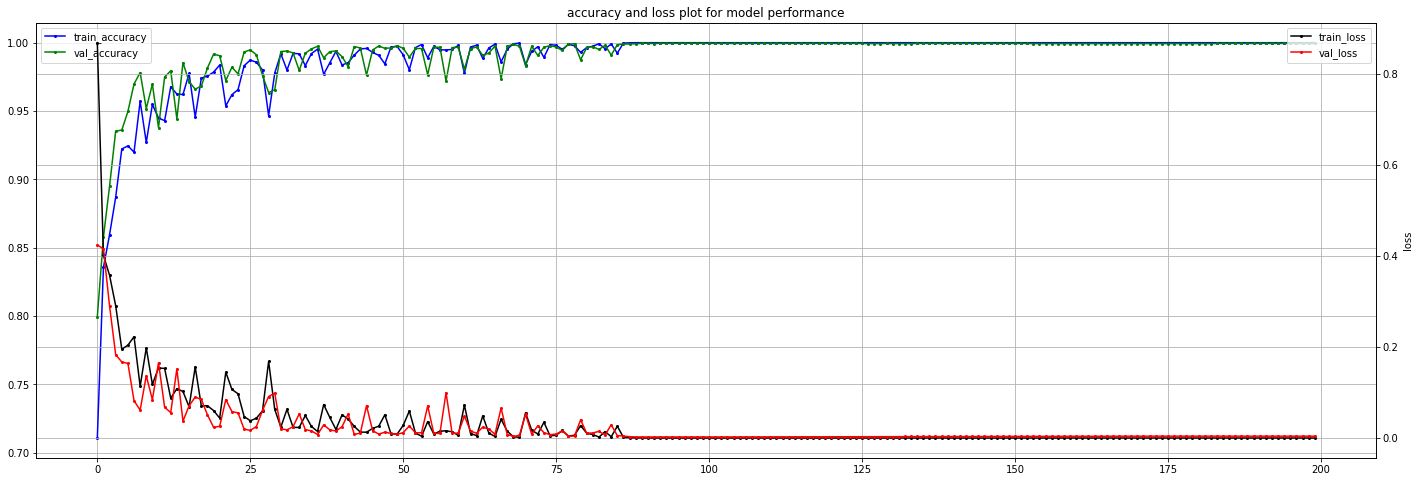

In [ ]:
plot_accuracy_loss_curve(history, use_pearson_corr = None, folder_path = None)

In [ ]:
y_pred = predict(model, x_test)

335/335 [==============================] - 2s 4ms/step


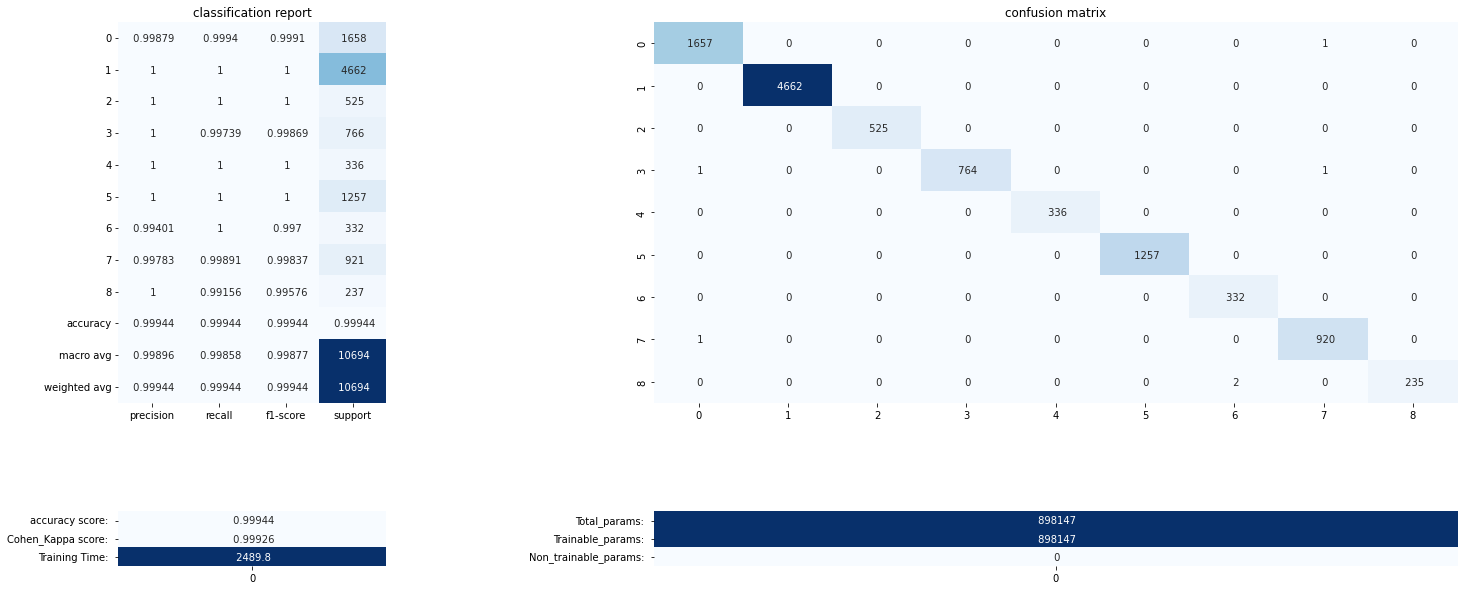

In [ ]:
performance_meausures(y_test, y_pred, tt, *parameters_summary, use_pearson_corr = None, folder_path = folder_path)

In [ ]:
for i in range(10):
    gc.collect()

In [ ]:
if use_pearson_corr:
    filepath1 = folder_path +"Results/ "+ str(train_percent)+"% performance.txt"
else:
    filepath1 = folder_path +"Results/"+ str(train_percent)+"% performance_ps_"+str(P_S)+".txt"
results = confusion_matrix(y_test,y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print(" ", file = open(filepath1, "a"))
print("P_S = ", P_S, file = open(filepath1, "a"))
print('Confusion Matrix :', file=open(filepath1,"a"))
print(results, file=open(filepath1,"a"))

print('Report : ', file=open(filepath1,"a"))
print(report, file=open(filepath1,"a"))

print('Accuracy Score :', accuracy, file=open(filepath1,"a")) 
print('Cohen_Kappa: ', kappa, file=open(filepath1,"a"))
print('Training Time:', tt, file=open(filepath1,"a"))

print("\033[1m", 'Confusion Matrix :', "\033[0m")
print(results) 
print("\033[1m", 'Report : ', "\033[0m")
print(report)
print("\033[1m", 'Accuracy Score :', "\033[0m", accuracy) 
print("\033[1m", 'Cohen_Kappa: ',  "\033[0m", kappa)
print("\033[1m", 'Training Time:', "\033[0m", tt)
print("\033[1m", "Total_params: ", "\033[0m", Total_params)
print("\033[1m", "Trainable_params: ", "\033[0m", Trainable_params)
print("\033[1m", "Non_trainable_params: ", "\033[0m", Non_trainable_params)

 Confusion Matrix : 
[[1657    0    0    0    0    0    0    1    0]
 [   0 4662    0    0    0    0    0    0    0]
 [   0    0  525    0    0    0    0    0    0]
 [   1    0    0  764    0    0    0    1    0]
 [   0    0    0    0  336    0    0    0    0]
 [   0    0    0    0    0 1257    0    0    0]
 [   0    0    0    0    0    0  332    0    0]
 [   1    0    0    0    0    0    0  920    0]
 [   0    0    0    0    0    0    2    0  235]]
 Report :  
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1658
           1       1.00      1.00      1.00      4662
           2       1.00      1.00      1.00       525
           3       1.00      1.00      1.00       766
           4       1.00      1.00      1.00       336
           5       1.00      1.00      1.00      1257
           6       0.99      1.00      1.00       332
           7       1.00      1.00      1.00       921
           8       1.00      0.99      1.00    

In [ ]:
y_hat = predict_image(model, padded_x, H, W, B, P_S)

In [ ]:
y_hat = y_hat.reshape((H,W))
a_c = np.unique(y_hat,return_counts=True)
print(a_c)
print(a_c,file=open(filepath1,"a"))

(array([1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([26669, 47732, 11050, 48616,  4322, 29875,  9264, 21133,  8739]))


In [ ]:
y_hat = y_hat.reshape((H,W))

In [6]:
img_path = folder_path + "Results/" + str(train_percent) + "% ps_" +str(P_S) + " predicted_image" + ".png"
spectral.save_rgb(img_path, y_hat, colors = spectral.spy_colors)
spectral.save_rgb("available_image.png", y, colors = spectral.spy_colors)

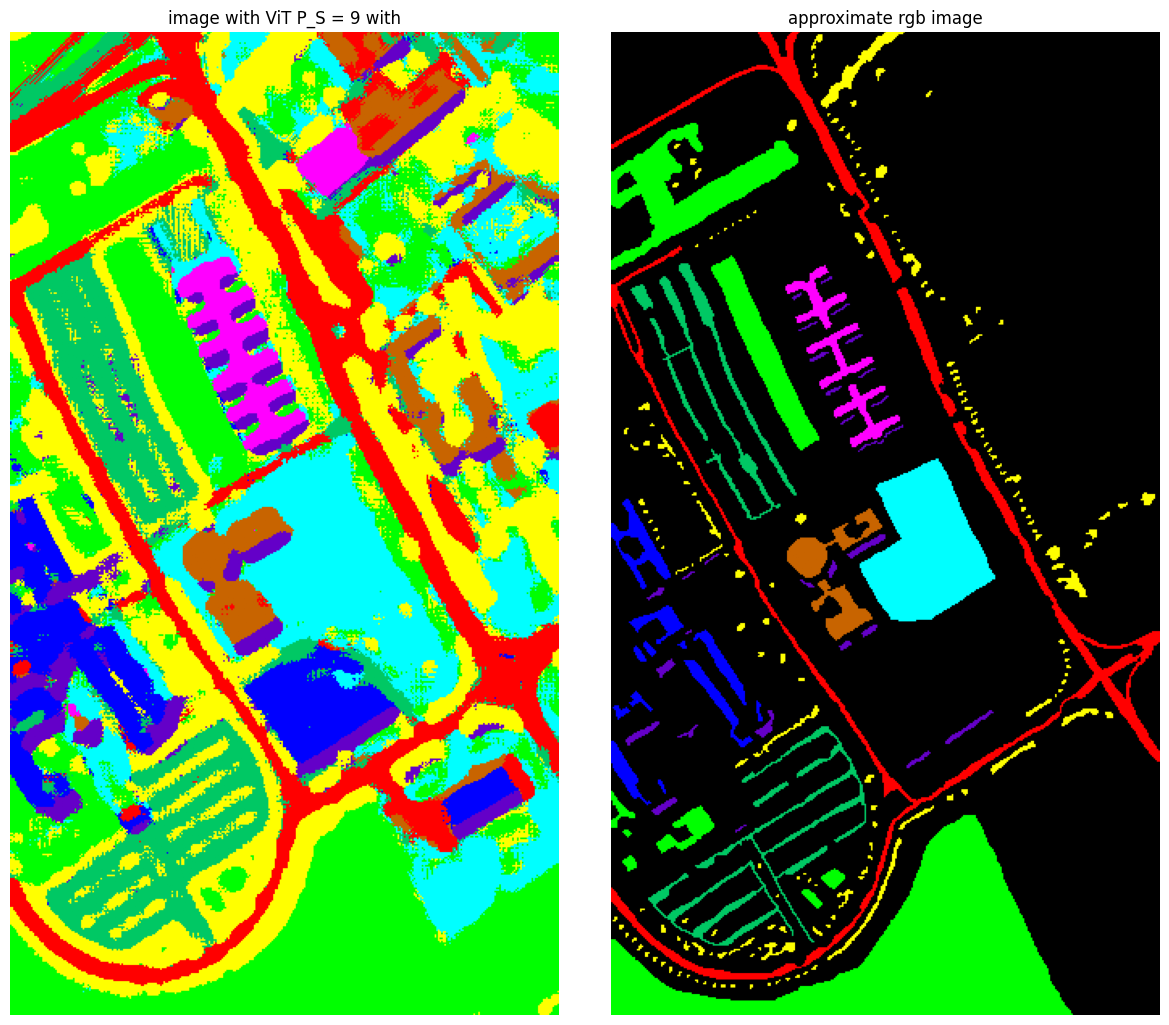

In [9]:
# img_path = folder_path + "Results/" + str(train_percent) + "% ps_" +str(P_S) + " predicted_image" + ".png"
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize = (12, 10))
img = plt.imread(img_path)
ax1.imshow(plt.imread(img_path))
ax1.set_title("image with ViT P_S = 9 with")
ax1.axis("off")

ax2.imshow(plt.imread("/content/available_image.png"))
ax2.set_title("approximate rgb image")
ax2.axis("off")

plt.tight_layout(pad = 0, h_pad=0, w_pad=0.2)
plt.show()

In [ ]:
MLP/Spatial-Shift-MLP/Version-1